In [547]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Z-score

In [548]:
def zScoreScale(x):
    data = x
    mean = data.mean()
    sig = np.sqrt(((data - mean)**2).sum())
    scaled_x = np.zeros(x.shape)
    
    scaled_data = (data - mean)/sig
    for i in range(x.shape[1]):
        scaled_x[:,i] = scaled_data[:,i]
    return scaled_x, mean, sig

def zScoreDescale(x, mean, sig):
    scaled_data = x
    descaled_data = scaled_data * sig + mean
    
    descaled_x = np.zeros(x.shape)
    for i in range(x.shape[1]):
        descaled_x[:,i] = descaled_data[:,i]
        
    return descaled_x

## Redes neurais

In [549]:
class TanhRegressionNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TanhRegressionNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.output(self.tanh(self.hidden(x)))

    def train(self, x_train, y_train, learning_rate=0.001, momentum=0.9, weight_decay=0.001, num_epochs=250, batch_size=32):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        loss_values = np.zeros(num_epochs)
        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            indices = torch.randperm(x_train.shape[0])
            x_it = x_train[indices]
            y_it = y_train[indices]

            for i in range(0, x_it.shape[0], batch_size):
                inputs = x_it[i:i + batch_size]
                targets = y_it[i:i + batch_size]

                optimizer.zero_grad()

                output = self(inputs)
                loss = criterion(output, targets)

                # L2 regularization
                # l2_regularization = 0.0
                # for param in self.parameters():
                #    l2_regularization += torch.norm(param, p=2)

                # loss += weight_decay * l2_regularization

                loss.backward()
                optimizer.step()

            loss_values[epoch] = loss.item()

        return loss_values
        

In [550]:
class ReLUClassificationNeuralNetwork():
    def __init__(self, input_size, hidden_size, output_size, dim):
        super(RegressionNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim = dim)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x
    
    def train(self, x_train, y_train, learning_rate = 0.001, momentum = 0.9, num_epochs = 250, batch_size = 32):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        lossValues = np.zeros(num_epochs)
        lossFunction = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):

            indices = torch.randperm(x_train.shape[0])
            x_it = x_train[indices]
            y_it = y_train[indices]

            for i in range (0, x_it.shape[0], batch_size):
                inputs = x_it[i:i+batch_size]
                targets = y_it[i:i+batch_size]

                optimizer.zero_grad()

                output = self(inputs)
                loss = lossFunction(output, targets)

                loss.backward()
                optimizer.step()

            lossValues[epoch] = loss.item()
        
        return lossValues


## Random Search

In [551]:
def random_search_tanh(x, y, x_validation, y_validation, num_models = 10, num_epochs= 250):
    best_loss = float('inf')
    best_hyperparameters = None
    input_size = x.shape[1]
    output_size = 1
    iterations = []
    criterion = nn.MSELoss()

    for i in range(num_models):
        # Generate random hyperparameters
        hidden_size = random.choice([16, 32, 64, 128])
        learning_rate = random.uniform(0.00001, 0.1)
        weight_decay = random.uniform(0.00001, 0.01)
        momentum = random.uniform(0.5, 0.9)
        batch_size = random.choice([16, 32, 64, 128])

        hyperparameters = (hidden_size, learning_rate, weight_decay, momentum, batch_size)

        # Create the neural network with the random hyperparameters
        network = TanhRegressionNeuralNetwork(input_size, hidden_size, output_size)

        # Train the network and get the loss values
        loss_values = network.train(x, 
                                    y, 
                                    learning_rate = learning_rate, 
                                    weight_decay = weight_decay,
                                    momentum = momentum, 
                                    num_epochs = num_epochs, 
                                    batch_size = batch_size)

        # Get the final loss value
        loss = criterion(network(x_validation), y_validation).item()

        iterations.append([loss, hyperparameters])

        # Check if the current hyperparameters are the best
        if loss < best_loss:
            best_loss = loss
            best_hyperparameters = hyperparameters
        
        print("-------------- Modelo", i + 1, "--------------")
        print("MSE =", loss)
        print("Hidden layer neurons =", hidden_size)
        print("Learning rate =", learning_rate)
        print("Weight Decay =", weight_decay)
        print("Momentum =", momentum)
        print("Batch size =", batch_size)
        print("")
        

    return best_hyperparameters, best_loss, iterations

## Questão 1

### Preparação dos dados

In [552]:
data = np.genfromtxt("concrete.csv", delimiter=',')
normalized_data, mean, sig = zScoreScale(data)

# Índices
indices = np.random.permutation(data.shape[0]).reshape(-1,1)
train_index = (int) (np.floor(data.shape[0] * 0.6))
validation_index = (int) (np.floor(data.shape[0] * 0.8))

# Conjuntos de treino
train_x = torch.Tensor(data[:train_index, :8]).float()
train_y = torch.tensor(data[:train_index, 8].reshape(-1,1)).float()

normalized_train_x = torch.Tensor(normalized_data[:train_index, :8]).float()
normalized_train_y = torch.tensor(normalized_data[:train_index, 8].reshape(-1,1)).float()

# Conjuntos de validação
validation_x = torch.Tensor(data[train_index:validation_index, :8]).float()
validation_y = torch.Tensor(data[train_index:validation_index, 8].reshape(-1,1)).float()

normalized_validation_x = torch.Tensor(normalized_data[train_index:validation_index, :8]).float()
normalized_validation_y = torch.Tensor(normalized_data[train_index:validation_index, 8].reshape(-1,1)).float()

# Conjuntos de teste
test_x = torch.Tensor(data[validation_index:, :8]).float()
test_y = torch.Tensor(data[validation_index:, 8].reshape(-1,1)).float()

normalized_test_x = torch.Tensor(normalized_data[validation_index:, :8]).float()
normalized_test_y = torch.Tensor(normalized_data[validation_index:, 8].reshape(-1,1)).float()

# Conjuntos de treino finais (treino + validação)
final_train_x = torch.Tensor(data[:validation_index, :8]).float()
final_train_y = torch.Tensor(data[:validation_index, 8]).float()

normalized_final_train_x = torch.Tensor(normalized_data[:validation_index, :8]).float()
normalized_final_train_y = torch.Tensor(normalized_data[:validation_index, 8]).float()

### Encontrar hiperparâmetros via Random Search

In [553]:
hyperparameters, loss, iterations = random_search_tanh(normalized_train_x, 
                                                       normalized_train_y, 
                                                       normalized_validation_x, 
                                                       normalized_validation_y,
                                                       num_models = 10,
                                                       num_epochs = 500)

-------------- Modelo 1 --------------
MSE = 4.019149741907313e-07
Hidden layer neurons = 128
Learning rate = 0.0597648489073039
Weight Decay = 0.003838052942899504
Momentum = 0.8321963955511422
Batch size = 16

-------------- Modelo 2 --------------
MSE = 3.5356615057935414e-07
Hidden layer neurons = 32
Learning rate = 0.052302950643315714
Weight Decay = 0.002424850409196332
Momentum = 0.799176655868708
Batch size = 64

-------------- Modelo 3 --------------
MSE = 3.801926027335867e-07
Hidden layer neurons = 32
Learning rate = 0.07159541105562907
Weight Decay = 0.008372221900835329
Momentum = 0.5484378405874311
Batch size = 64

-------------- Modelo 4 --------------
MSE = 3.6260203728488705e-07
Hidden layer neurons = 128
Learning rate = 0.032106747696806055
Weight Decay = 0.0073696573664843515
Momentum = 0.5712071790551317
Batch size = 64



CONSULTE A TABELA NA CÉLULA ACIMA PARA VER OS HIPERPARÂMETROS DE CADA MODELO


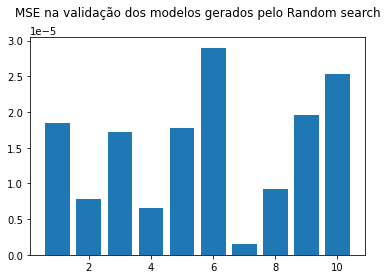

In [ ]:
print('CONSULTE A TABELA NA CÉLULA ACIMA PARA VER OS HIPERPARÂMETROS DE CADA MODELO')
labels = np.arange(len(iterations)) + 1
values = []
for (loss, hyper) in iterations:
    values.append(loss)

plt.title('MSE na validação dos modelos gerados pelo Random search\n')
plt.bar(labels, values, align='center')
plt.show()

In [ ]:
print('Melhores hiperparâmetros: ')
print("Hidden layer neurons =", hyperparameters[0])
print("Learning rate =", hyperparameters[1])
print("Weight Decay =", hyperparameters[2])
print("Momentum =", hyperparameters[3])
print("Batch size =", hyperparameters[4])
print("")

Melhores hiperparâmetros: 
Hidden layer neurons = 32
Learning rate = 0.011219198635277072
Weight Decay = 0.00129744575645032
Momentum = 0.623156554685248
Batch size = 32



### Treinar Rede neural final com hiperparâmetros obtidos

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


7.257692118400882e-07


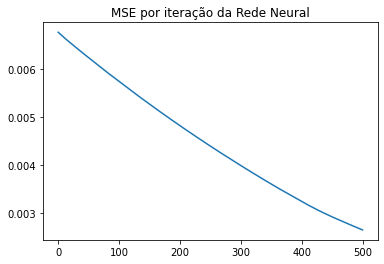

In [ ]:
regressor = TanhRegressionNeuralNetwork(8, hyperparameters[0], 1)

MSE = regressor.train(normalized_final_train_x, 
                      normalized_final_train_y, 
                      num_epochs=500, 
                      learning_rate=hyperparameters[1], 
                      weight_decay=hyperparameters[2], 
                      momentum=hyperparameters[3], 
                      batch_size=hyperparameters[4])

lossFunction = nn.MSELoss()

print(lossFunction(regressor(normalized_test_x), normalized_test_y).item())

plt.title("MSE por iteração da Rede Neural")
plt.plot(np.arange(MSE.size), MSE)
plt.show()

## Questão 2

In [ ]:
data = np.genfromtxt("vowel.csv", delimiter=',')

x = torch.Tensor(data[:, :10])
y = torch.Tensor(data[:, 10].reshape(-1, 1))

classificator = ReLUClassificationNeuralNetwork()

TypeError: ReLUClassificationNeuralNetwork.__init__() missing 4 required positional arguments: 'input_size', 'hidden_size', 'output_size', and 'dim'